# san

In [16]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import community as community_louvain

## eda - Overview

In [17]:
# Daten laden
edges = pd.read_csv('../data/edges.csv')
nodes = pd.read_csv('../data/nodes.csv')

nodes["Semester_num"] = pd.to_numeric(nodes["Semester"], errors="coerce")

In [18]:
G = nx.from_pandas_edgelist(edges, 'Source', 'Target', 
                           edge_attr='Label', create_using=nx.DiGraph())
nx.set_node_attributes(G, nodes.set_index('Id')['Gruppe'].to_dict(), 'Gruppe')
nx.set_node_attributes(G, nodes.set_index('Id')['Semester'].to_dict(), 'Semester')


print(f"Netzwerk: {G.number_of_nodes()} Knoten, {G.number_of_edges()} Kanten")

Netzwerk: 14 Knoten, 12 Kanten


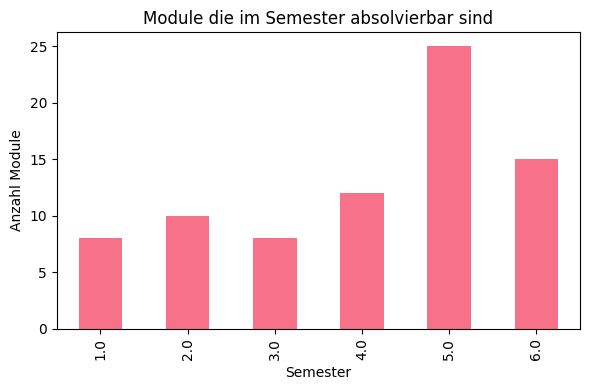

In [19]:
sem_counts = nodes["Semester_num"].value_counts().sort_index()

plt.figure(figsize=(6,4))
sem_counts.plot(kind="bar")
plt.xlabel("Semester")
plt.ylabel("Anzahl Module")
plt.title("Module die im Semester absolvierbar sind")
plt.tight_layout()
plt.show()



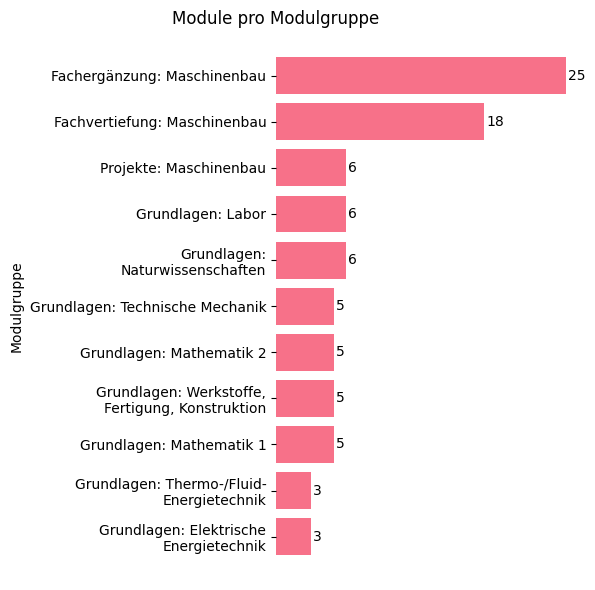

In [20]:
grp_counts = nodes["Gruppe"].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(6, 6))


bars = ax.barh(grp_counts.index, grp_counts.values)


for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)


ax.xaxis.set_visible(False)

ax.set_xlabel("") 
ax.set_ylabel("Modulgruppe")
ax.set_title(
    "Module pro Modulgruppe",
    loc="center",
    x=0  # 0.5 = exakt mittig, leicht anpassen z.B. 0.48 oder 0.52
)
# Werte rechts neben den Balken
for bar in bars:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(
        width + 0.2,      
        y,
        f"{int(width)}",   
        va="center",
        ha="left"
    )

plt.tight_layout()
plt.show()


## Netzwerk-Metriken

In [21]:
print("\n## Netzwerk-Metriken (Kapitel 8)")
density = nx.density(G)
print(f"Density: {density:.4f} (Kapitel 8.1)")

# Diameter nur fuer groessten strongly connected component
scc = list(nx.strongly_connected_components(G))
largest_scc = max(scc, key=len)
G_scc = G.subgraph(largest_scc).copy()
print(f"Strongly Connected Components: {nx.number_strongly_connected_components(G)} (Kapitel 5.1)")
print(f"Diameter groesster SCC: {nx.diameter(G_scc):.1f} (Kapitel 8.2)")

undir = G.to_undirected()
print(f"Avg Clustering Coeff: {nx.average_clustering(undir):.4f} (Kapitel 8.3)")


## Netzwerk-Metriken (Kapitel 8)
Density: 0.0659 (Kapitel 8.1)
Strongly Connected Components: 14 (Kapitel 5.1)
Diameter groesster SCC: 0.0 (Kapitel 8.2)
Avg Clustering Coeff: 0.0000 (Kapitel 8.3)


## Zentralität

In [22]:
print("\n## Zentralitaeten (Kapitel 6)")
deg_in = nx.in_degree_centrality(G)      # Indegree Prestige (6.2.1)
deg_out = nx.out_degree_centrality(G)    # Outdegree (6.1.1)
close = nx.closeness_centrality(G)
betw = nx.betweenness_centrality(G)
eig = nx.eigenvector_centrality(G, max_iter=1000)

cent_df = pd.DataFrame({
    'InDegree': pd.Series(deg_in),
    'OutDegree': pd.Series(deg_out), 
    'Closeness': pd.Series(close),
    'Betweenness': pd.Series(betw),
    'Eigenvector': pd.Series(eig)
}).round(4)

print("\nTop 5 Betweenness (Bruckenmodule, Kapitel 6.1.3):")
print(cent_df.sort_values('Betweenness', ascending=False).head())

print("\nTop 10 beliebteste Voraussetzungen (InDegree Prestige, Kapitel 6.2.1):")
print(cent_df.sort_values('InDegree', ascending=False).head(10))



## Zentralitaeten (Kapitel 6)

Top 5 Betweenness (Bruckenmodule, Kapitel 6.1.3):
       InDegree  OutDegree  Closeness  Betweenness  Eigenvector
pro4M    0.3077     0.0769     0.4154       0.1154       0.0001
pro3M    0.3077     0.0769     0.3205       0.0962       0.0000
pro5M    0.0769     0.0769     0.3077       0.0641       0.0083
pro2M    0.0769     0.0769     0.0769       0.0256       0.0000
wch      0.0769     0.0000     0.0769       0.0000       0.0000

Top 10 beliebteste Voraussetzungen (InDegree Prestige, Kapitel 6.2.1):
       InDegree  OutDegree  Closeness  Betweenness  Eigenvector
pro3M    0.3077     0.0769     0.3205       0.0962       0.0000
pro4M    0.3077     0.0769     0.4154       0.1154       0.0001
pro2M    0.0769     0.0769     0.0769       0.0256       0.0000
pro5M    0.0769     0.0769     0.3077       0.0641       0.0083
pro6M    0.0769     0.0000     0.2585       0.0000       1.0000
wch      0.0769     0.0000     0.0769       0.0000       0.0000
stk      0.000

## Communities

In [23]:
print("\n## Communities (Kapitel 5)")
partition = community_louvain.best_partition(undir)
modularity = community_louvain.modularity(partition, undir)
louvain_count = len(set(partition.values()))
print(f"Louvain Communities: {louvain_count} (Kapitel 5.3.3)")
print(f"Modularity: {modularity:.4f}")

# Community-Zuordnung anzeigen
comm_df = pd.DataFrame(list(partition.items()), columns=['Modul', 'Community'])
print("\nTop Communities (Modulanzahl):")
print(comm_df.groupby('Community').size().sort_values(ascending=False).head())



## Communities (Kapitel 5)
Louvain Communities: 5 (Kapitel 5.3.3)
Modularity: 0.4896

Top Communities (Modulanzahl):
Community
1    4
4    4
0    2
2    2
3    2
dtype: int64


## Assortativität

In [24]:
print("\n## Assortativitaet (Kapitel 10.4)")
group_assort = nx.attribute_assortativity_coefficient(undir, 'Gruppe')
semester_assort = nx.attribute_assortativity_coefficient(undir, 'Semester')
print(f"Assortativitaet Gruppe: {group_assort:.4f}")
print(f"Assortativitaet Semester: {semester_assort:.4f}")


## Assortativitaet (Kapitel 10.4)
Assortativitaet Gruppe: -0.1126
Assortativitaet Semester: 0.1504


## Zentralisierung

In [25]:
print("\n## Zentralisierung (Kapitel 7)")
deg_centralization = nx.degree_centrality(G)
centralization_deg = max(deg_centralization.values()) - np.mean(list(deg_centralization.values()))
print(f"Degree Zentralisierung: {centralization_deg:.4f} (Kapitel 7.1)")


## Zentralisierung (Kapitel 7)
Degree Zentralisierung: 0.2527 (Kapitel 7.1)


## Gruppen-Statistik

In [26]:
print("\n## Gruppen-Statistik")
gruppe_stats = nodes.groupby('Gruppe').size()
print(gruppe_stats.sort_values(ascending=False))



## Gruppen-Statistik
Gruppe
Fachergänzung: Maschinenbau                         25
Fachvertiefung: Maschinenbau                        18
Grundlagen:\nNaturwissenschaften                     6
Grundlagen: Labor                                    6
Projekte: Maschinenbau                               6
Grundlagen: Mathematik 2                             5
Grundlagen: Mathematik 1                             5
Grundlagen: Werkstoffe,\nFertigung, Konstruktion     5
Grundlagen: Technische Mechanik                      5
Grundlagen: Elektrische\nEnergietechnik              3
Grundlagen: Thermo-/Fluid-\nEnergietechnik           3
dtype: int64
